<a href="https://colab.research.google.com/github/royleekiat/Employee_attrition_predictor/blob/main/Employee_attrition_predictor_Roy_Lee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background

Model is based on [Red Dragon AI](http://reddragonai.com/)'s class [example](https://colab.research.google.com/drive/1ZxQCuf6Y6zKK9MhTQVnHRI-epfRsUgoP?usp=sharing)


**Structured data classification from scratch**

**Author**: [fchollet](https://twitter.com/fchollet)

**Description**: Binary classification of structured data including numerical and categorical features.




# Dataset

This project targets to predict employee attrition based on Kaggle dataset [Employee Attrition](https://www.kaggle.com/colearninglounge/employee-attrition)

#Install & import

Install Tensorflow 2.3 or tf-nightly

In [1]:
%pip -q install tf-nightly

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import math
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, TensorBoard


In [3]:
tf.__version__

'2.4.0-dev20201002'

# Read files

I downloaded the files from Kaggle and hosted the files on my Google drive as csv

In [4]:
#Training and validation dataset
file_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRTzmPbXWcC6mfBDE1MBg5HoHsYlvYtkZp8oJFHfIMNzqiG6P4cdGaceWsxW9JS6ip9vdJYCNrDEbOx/pub?gid=581336355&single=true&output=csv"
dataframe = pd.read_csv(file_url)
dataframe.shape




(1029, 37)

In [5]:
#Test dataset
test_file_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRsxR0nTrEaCqfro4FvGNDn6ZYYdQS0e2Tev1SMtJ5jYIjU0WGp77hp6btdJYkMl3XAk4lA01hxE30o/pub?gid=2057317048&single=true&output=csv"
test_dataframe = pd.read_csv(test_file_url)
test_dataframe.shape

(441, 34)

In [6]:
dataframe.head(n=20)

,id,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,AttritionBinary
0,1,50,No,Travel_Rarely,1126,Research & Development,1,2,Medical,1,997,4,Male,66,3,4,Research Director,4,Divorced,17399,6615,9,Y,No,22,4,3,80,1,32,1,2,5,4,1,3,0
1,2,36,No,Travel_Rarely,216,Research & Development,6,2,Medical,1,178,2,Male,84,3,2,Manufacturing Director,2,Divorced,4941,2819,6,Y,No,20,4,4,80,2,7,0,3,3,2,0,1,0
2,3,21,Yes,Travel_Rarely,337,Sales,7,1,Marketing,1,1780,2,Male,31,3,1,Sales Representative,2,Single,2679,4567,1,Y,No,13,3,2,80,0,1,3,3,1,0,1,0,1
3,4,50,No,Travel_Frequently,1246,Human Resources,1,3,Medical,1,644,1,Male,99,3,5,Manager,2,Married,18200,7999,1,Y,No,11,3,3,80,1,32,2,3,32,5,10,7,0
4,5,52,No,Travel_Rarely,994,Research & Development,7,4,Life Sciences,1,1118,2,Male,87,3,3,Healthcare Representative,2,Single,10445,15322,7,Y,No,19,3,4,80,0,18,4,3,8,6,4,0,0
5,6,33,Yes,Travel_Rarely,1277,Research & Development,15,1,Medical,1,582,2,Male,56,3,3,Manager,3,Married,13610,24619,7,Y,Yes,12,3,4,80,0,15,2,4,7,6,7,7,1
6,7,47,No,Travel_Rarely,1001,Research & Development,4,3,Life Sciences,1,1827,3,Female,92,2,3,Manufacturing Director,2,Divorced,10333,19271,8,Y,Yes,12,3,3,80,1,28,4,3,22,11,14,10,0
7,8,22,No,Travel_Rarely,1230,Research & Development,1,2,Life Sciences,1,872,4,Male,33,2,2,Manufacturing Director,4,Married,4775,19146,6,Y,No,22,4,1,80,2,4,2,1,2,2,2,2,0
8,9,40,Yes,Travel_Rarely,890,Research & Development,2,4,Medical,1,828,3,Male,46,3,1,Research Scientist,3,Single,4382,16374,6,Y,No,17,3,4,80,0,5,3,2,2,2,2,1,1
9,10,33,No,Non-Travel,530,Sales,16,3,Life Sciences,1,1681,3,Female,36,3,2,Sales Executive,4,Divorced,5368,16130,1,Y,Yes,25,4,3,80,1,7,2,3,6,5,1,2,0


I added a column "AttritionBinary" beside to the dataset to make it easier to process the data :) . No = 0, 1 = Yes. 

The data has 1029 rows and 36 columns.

In [7]:
test_dataframe.head(n=20)

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,NaN,Travel_Rarely,866.0,Sales,NaN,3,Medical,1,1469,4,Male,84,3,2,Sales Executive,1,Single,8463,23490,0,Y,No,18,3,4,80,0,6,4,3,5,4,1,3
1,53.0,Travel_Rarely,1084.0,Research & Development,13.0,2,Medical,1,250,4,Female,57,4,2,Manufacturing Director,1,Divorced,4450,26250,1,Y,No,11,3,3,80,2,5,3,3,4,2,1,3
2,24.0,Travel_Rarely,240.0,Human Resources,22.0,1,Human Resources,1,1714,4,Male,58,1,1,Human Resources,3,Married,1555,11585,1,Y,No,11,3,3,80,1,1,2,3,1,0,0,0
3,45.0,Travel_Rarely,1339.0,Research & Development,7.0,3,Life Sciences,1,86,2,Male,59,3,3,Research Scientist,1,Divorced,9724,18787,2,Y,No,17,3,3,80,1,25,2,3,1,0,0,0
4,36.0,Travel_Rarely,1396.0,Research & Development,NaN,2,Life Sciences,1,304,4,Male,62,3,2,Laboratory Technician,2,Single,5914,9945,8,Y,No,16,3,4,80,0,16,3,4,13,11,3,7
5,34.0,Travel_Rarely,204.0,Sales,14.0,3,Technical Degree,1,666,3,Female,31,3,1,Sales Representative,3,Divorced,2579,2912,1,Y,Yes,18,3,4,80,2,8,3,3,8,2,0,6
6,NaN,Travel_Rarely,144.0,Research & Development,22.0,3,Life Sciences,1,577,4,Male,46,1,1,Laboratory Technician,3,Single,4230,19225,0,Y,No,15,3,3,80,0,6,2,3,5,4,4,3
7,39.0,Travel_Rarely,1431.0,Research & Development,1.0,4,Medical,1,332,3,Female,96,3,1,Laboratory Technician,3,,2232,15417,7,Y,No,14,3,3,80,3,7,1,3,3,2,1,2
8,45.0,Non-Travel,1052.0,Sales,6.0,3,Medical,1,302,4,Female,57,2,3,Sales Executive,4,Single,8865,16840,6,Y,No,12,3,4,80,0,23,2,3,19,7,12,8
9,NaN,Travel_Rarely,1229.0,Research & Development,8.0,1,Life Sciences,1,63,4,Male,36,4,1,Laboratory Technician,4,Married,2269,4892,1,Y,No,19,3,4,80,0,1,2,3,1,0,0,1


# Drop columns that I do not intend to use as features 

Dropping these useless columns
- id	
- Attrition	
- EmployeeCount	
- EmployeeNumber

In [8]:
dataframe = dataframe.drop(['id','Attrition','EmployeeCount','EmployeeNumber'], axis=1)

dataframe.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,AttritionBinary
0,50,Travel_Rarely,1126,Research & Development,1,2,Medical,4,Male,66,3,4,Research Director,4,Divorced,17399,6615,9,Y,No,22,4,3,80,1,32,1,2,5,4,1,3,0
1,36,Travel_Rarely,216,Research & Development,6,2,Medical,2,Male,84,3,2,Manufacturing Director,2,Divorced,4941,2819,6,Y,No,20,4,4,80,2,7,0,3,3,2,0,1,0
2,21,Travel_Rarely,337,Sales,7,1,Marketing,2,Male,31,3,1,Sales Representative,2,Single,2679,4567,1,Y,No,13,3,2,80,0,1,3,3,1,0,1,0,1
3,50,Travel_Frequently,1246,Human Resources,1,3,Medical,1,Male,99,3,5,Manager,2,Married,18200,7999,1,Y,No,11,3,3,80,1,32,2,3,32,5,10,7,0
4,52,Travel_Rarely,994,Research & Development,7,4,Life Sciences,2,Male,87,3,3,Healthcare Representative,2,Single,10445,15322,7,Y,No,19,3,4,80,0,18,4,3,8,6,4,0,0


# Splitting dataset into Training and Validation 

- Training: 80% 
- Validation: 20%

In [9]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)


print(
    "Using %d samples for training, %d for validation and %d for test"
    % (len(train_dataframe), len(val_dataframe), len(test_dataframe))
)

Using 823 samples for training, 206 for validation and 441 for test


In [10]:

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("AttritionBinary")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def test_dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe)))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds



train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)
test_ds = test_dataframe_to_dataset(test_dataframe)

In [11]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'Age': <tf.Tensor: shape=(), dtype=int64, numpy=24>, 'BusinessTravel': <tf.Tensor: shape=(), dtype=string, numpy=b'Travel_Rarely'>, 'DailyRate': <tf.Tensor: shape=(), dtype=int64, numpy=984>, 'Department': <tf.Tensor: shape=(), dtype=string, numpy=b'Research & Development'>, 'DistanceFromHome': <tf.Tensor: shape=(), dtype=int64, numpy=17>, 'Education': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'EducationField': <tf.Tensor: shape=(), dtype=string, numpy=b'Life Sciences'>, 'EnvironmentSatisfaction': <tf.Tensor: shape=(), dtype=int64, numpy=4>, 'Gender': <tf.Tensor: shape=(), dtype=string, numpy=b'Female'>, 'HourlyRate': <tf.Tensor: shape=(), dtype=int64, numpy=97>, 'JobInvolvement': <tf.Tensor: shape=(), dtype=int64, numpy=3>, 'JobLevel': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'JobRole': <tf.Tensor: shape=(), dtype=string, numpy=b'Laboratory Technician'>, 'JobSatisfaction': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'MaritalStatus': <tf.Tensor: shape=(), dtype=string, 

In [12]:
train_ds = train_ds.batch(64)
val_ds = val_ds.batch(64)

Feature preprocessing with Keras layers
The following features are categorical features encoded as integers:

- Education	
- EnvironmentSatisfaction	
- JobInvolvement	
- JobLevel	
- JobSatisfaction	
- PerformanceRating	
- RelationshipSatisfaction	
- StandardHours	
- StockOptionLevel	
- WorkLifeBalance	


We will encode these features using one-hot encoding using the CategoryEncoding() layer.

We also have some categorical features encoded as strings: 

- BusinessTravel	
- Department	
- EducationField	
- Gender	
- JobRole	
- MaritalStatus	
- Over18	
- OverTime

We will first create an index of all possible features using the StringLookup() layer, then we will one-hot encode the output indices using a CategoryEncoding() layer.

Finally, the following feature are continuous numerical features:

- Age	
- DailyRate
- DistanceFromHome	
- HourlyRate	
- MonthlyIncome	
- MonthlyRate	
- NumCompaniesWorked	
- PercentSalaryHike	
- TotalWorkingYears	
- TrainingTimesLastYear	
- YearsAtCompany	
- YearsInCurrentRole	
- YearsSinceLastPromotion	
- YearsWithCurrManager	


For each of these features, we will use a Normalization() layer to make sure the mean of each feature is 0 and its standard deviation is 1.

Below, we define 3 utility functions to do the operations:

encode_numerical_feature to apply featurewise normalization to numerical features.
encode_string_categorical_feature to first turn string inputs into integer indices, then one-hot encode these integer indices.
encode_integer_categorical_feature to one-hot encode integer categorical features.

In [13]:
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.layers.experimental.preprocessing import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_string_categorical_feature(feature, name, dataset):
    # Create a StringLookup layer which will turn strings into integer indices
    index = StringLookup()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    index.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = index(feature)

    # Create a CategoryEncoding for our integer indices
    encoder = CategoryEncoding(output_mode="binary")

    # Prepare a dataset of indices
    feature_ds = feature_ds.map(index)

    # Learn the space of possible indices
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices
    encoded_feature = encoder(encoded_feature)
    return encoded_feature


def encode_integer_categorical_feature(feature, name, dataset):
    # Create a CategoryEncoding for our integer indices
    encoder = CategoryEncoding(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the space of possible indices
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices
    encoded_feature = encoder(feature)
    return encoded_feature



Build Model

In [14]:
# Categorical features encoded as integers
'''
Education
EnvironmentSatisfaction
JobInvolvement
JobLevel
JobSatisfaction
PerformanceRating
RelationshipSatisfaction
StandardHours
StockOptionLevel
WorkLifeBalance
'''
Education = keras.Input(shape=(1,), name="Education", dtype="int64")
EnvironmentSatisfaction = keras.Input(shape=(1,), name="EnvironmentSatisfaction", dtype="int64")
JobInvolvement = keras.Input(shape=(1,), name="JobInvolvement", dtype="int64")
JobLevel = keras.Input(shape=(1,), name="JobLevel", dtype="int64")
JobSatisfaction = keras.Input(shape=(1,), name="JobSatisfaction", dtype="int64")
PerformanceRating = keras.Input(shape=(1,), name="PerformanceRating", dtype="int64")
RelationshipSatisfaction = keras.Input(shape=(1,), name="RelationshipSatisfaction", dtype="int64")
StandardHours = keras.Input(shape=(1,), name="StandardHours", dtype="int64")
StockOptionLevel = keras.Input(shape=(1,), name="StockOptionLevel", dtype="int64")
WorkLifeBalance = keras.Input(shape=(1,), name="WorkLifeBalance", dtype="int64")

# Categorical feature encoded as string
'''
BusinessTravel
Department
EducationField
Gender
JobRole
MaritalStatus
Over18
OverTime
'''
BusinessTravel = keras.Input(shape=(1,), name="BusinessTravel", dtype="string")
Department = keras.Input(shape=(1,), name="Department", dtype="string")
EducationField = keras.Input(shape=(1,), name="EducationField", dtype="string")
Gender = keras.Input(shape=(1,), name="Gender", dtype="string")
JobRole = keras.Input(shape=(1,), name="JobRole", dtype="string")
MaritalStatus = keras.Input(shape=(1,), name="MaritalStatus", dtype="string")
Over18 = keras.Input(shape=(1,), name="Over18", dtype="string")
OverTime = keras.Input(shape=(1,), name="OverTime", dtype="string")

# Numerical features

'''
Age
DailyRate
DistanceFromHome
HourlyRate
MonthlyIncome
MonthlyRate
NumCompaniesWorked
PercentSalaryHike
TotalWorkingYears
TrainingTimesLastYear
YearsAtCompany
YearsInCurrentRole
YearsSinceLastPromotion
YearsWithCurrManager
'''

Age = keras.Input(shape=(1,), name="Age")
DailyRate = keras.Input(shape=(1,), name="DailyRate")
DistanceFromHome = keras.Input(shape=(1,), name="DistanceFromHome")
HourlyRate = keras.Input(shape=(1,), name="HourlyRate")
MonthlyIncome = keras.Input(shape=(1,), name="MonthlyIncome")
MonthlyRate = keras.Input(shape=(1,), name="MonthlyRate")
NumCompaniesWorked = keras.Input(shape=(1,), name="NumCompaniesWorked")
PercentSalaryHike = keras.Input(shape=(1,), name="PercentSalaryHike")
TotalWorkingYears = keras.Input(shape=(1,), name="TotalWorkingYears")
TrainingTimesLastYear = keras.Input(shape=(1,), name="TrainingTimesLastYear")
YearsAtCompany = keras.Input(shape=(1,), name="YearsAtCompany")
YearsInCurrentRole = keras.Input(shape=(1,), name="YearsInCurrentRole")
YearsSinceLastPromotion = keras.Input(shape=(1,), name="YearsSinceLastPromotion")
YearsWithCurrManager = keras.Input(shape=(1,), name="YearsWithCurrManager")

all_inputs = [
    Education,
    EnvironmentSatisfaction,
    JobInvolvement,
    JobLevel,
    JobSatisfaction,
    PerformanceRating,
    RelationshipSatisfaction,
    StandardHours,
    StockOptionLevel,
    WorkLifeBalance,

    BusinessTravel,
    Department,
    EducationField,
    Gender,
    JobRole,
    MaritalStatus,
    Over18,
    OverTime,

    Age,
    DailyRate,
    DistanceFromHome,
    HourlyRate,
    MonthlyIncome,
    MonthlyRate,
    NumCompaniesWorked,
    PercentSalaryHike,
    TotalWorkingYears,
    TrainingTimesLastYear,
    YearsAtCompany,
    YearsInCurrentRole,
    YearsSinceLastPromotion,
    YearsWithCurrManager
]

# Integer categorical features
Education_encoded = encode_integer_categorical_feature(Education, "Education", train_ds)
EnvironmentSatisfaction_encoded = encode_integer_categorical_feature(EnvironmentSatisfaction, "EnvironmentSatisfaction", train_ds)
JobInvolvement_encoded = encode_integer_categorical_feature(JobInvolvement, "JobInvolvement", train_ds)
JobLevel_encoded = encode_integer_categorical_feature(JobLevel, "JobLevel", train_ds)
JobSatisfaction_encoded = encode_integer_categorical_feature(JobSatisfaction, "JobSatisfaction", train_ds)
PerformanceRating_encoded = encode_integer_categorical_feature(PerformanceRating, "PerformanceRating", train_ds)
RelationshipSatisfaction_encoded = encode_integer_categorical_feature(RelationshipSatisfaction, "RelationshipSatisfaction", train_ds)
StandardHours_encoded = encode_integer_categorical_feature(StandardHours, "StandardHours", train_ds)
StockOptionLevel_encoded = encode_integer_categorical_feature(StockOptionLevel, "StockOptionLevel", train_ds)
WorkLifeBalance_encoded = encode_integer_categorical_feature(WorkLifeBalance, "WorkLifeBalance", train_ds)

# String categorical features
BusinessTravel_encoded = encode_string_categorical_feature(BusinessTravel, "BusinessTravel", train_ds)
Department_encoded = encode_string_categorical_feature(Department, "Department", train_ds)
EducationField_encoded = encode_string_categorical_feature(EducationField, "EducationField", train_ds)
Gender_encoded = encode_string_categorical_feature(Gender, "Gender", train_ds)
JobRole_encoded = encode_string_categorical_feature(JobRole, "JobRole", train_ds)
MaritalStatus_encoded = encode_string_categorical_feature(MaritalStatus, "MaritalStatus", train_ds)
Over18_encoded = encode_string_categorical_feature(Over18, "Over18", train_ds)
OverTime_encoded = encode_string_categorical_feature(OverTime, "OverTime", train_ds)

# Numerical features
Age_encoded = encode_numerical_feature(Age, "Age", train_ds)
DailyRate_encoded = encode_numerical_feature(DailyRate, "DailyRate", train_ds)
DistanceFromHome_encoded = encode_numerical_feature(DistanceFromHome, "DistanceFromHome", train_ds)
HourlyRate_encoded = encode_numerical_feature(HourlyRate, "HourlyRate", train_ds)
MonthlyIncome_encoded = encode_numerical_feature(MonthlyIncome, "MonthlyIncome", train_ds)
MonthlyRate_encoded = encode_numerical_feature(MonthlyRate, "MonthlyRate", train_ds)
NumCompaniesWorked_encoded = encode_numerical_feature(NumCompaniesWorked, "NumCompaniesWorked", train_ds)
PercentSalaryHike_encoded = encode_numerical_feature(PercentSalaryHike, "PercentSalaryHike", train_ds)
TotalWorkingYears_encoded = encode_numerical_feature(TotalWorkingYears, "TotalWorkingYears", train_ds)
TrainingTimesLastYear_encoded = encode_numerical_feature(TrainingTimesLastYear, "TrainingTimesLastYear", train_ds)
YearsAtCompany_encoded = encode_numerical_feature(YearsAtCompany, "YearsAtCompany", train_ds)
YearsInCurrentRole_encoded = encode_numerical_feature(YearsInCurrentRole, "YearsInCurrentRole", train_ds)
YearsSinceLastPromotion_encoded = encode_numerical_feature(YearsSinceLastPromotion, "YearsSinceLastPromotion", train_ds)
YearsWithCurrManager_encoded = encode_numerical_feature(YearsWithCurrManager, "YearsWithCurrManager", train_ds)

all_features = layers.concatenate(
    [
      Education_encoded,
      EnvironmentSatisfaction_encoded,
      JobInvolvement_encoded,
      JobLevel_encoded,
      JobSatisfaction_encoded,
      PerformanceRating_encoded,
      RelationshipSatisfaction_encoded,
      StandardHours_encoded,
      StockOptionLevel_encoded,
      WorkLifeBalance_encoded,
      BusinessTravel_encoded,
      Department_encoded,
      EducationField_encoded,
      Gender_encoded,
      JobRole_encoded,
      MaritalStatus_encoded,
      Over18_encoded,
      OverTime_encoded,
      Age_encoded,
      DailyRate_encoded,
      DistanceFromHome_encoded,
      HourlyRate_encoded,
      MonthlyIncome_encoded,
      MonthlyRate_encoded,
      NumCompaniesWorked_encoded,
      PercentSalaryHike_encoded,
      TotalWorkingYears_encoded,
      TrainingTimesLastYear_encoded,
      YearsAtCompany_encoded,
      YearsInCurrentRole_encoded,
      YearsSinceLastPromotion_encoded,
      YearsWithCurrManager_encoded
    ]
)

# Multiple layers with dropout (for higher accuracy)

x = layers.Dense(64, activation="relu", name = "Dense_1")(all_features)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation="relu", name = "Dense_2")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation="relu", name = "Dense_3")(x)
output = layers.Dense(1, activation="sigmoid",name = "Outputlayer")(x)

model = keras.Model(all_inputs, output)

#Use Adam optimizer with custom learning rate

opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(opt, "binary_crossentropy", metrics=["accuracy"])

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
BusinessTravel (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
Department (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
EducationField (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
Gender (InputLayer)             [(None, 1)]          0                                            
______________________________________________________________________________________________

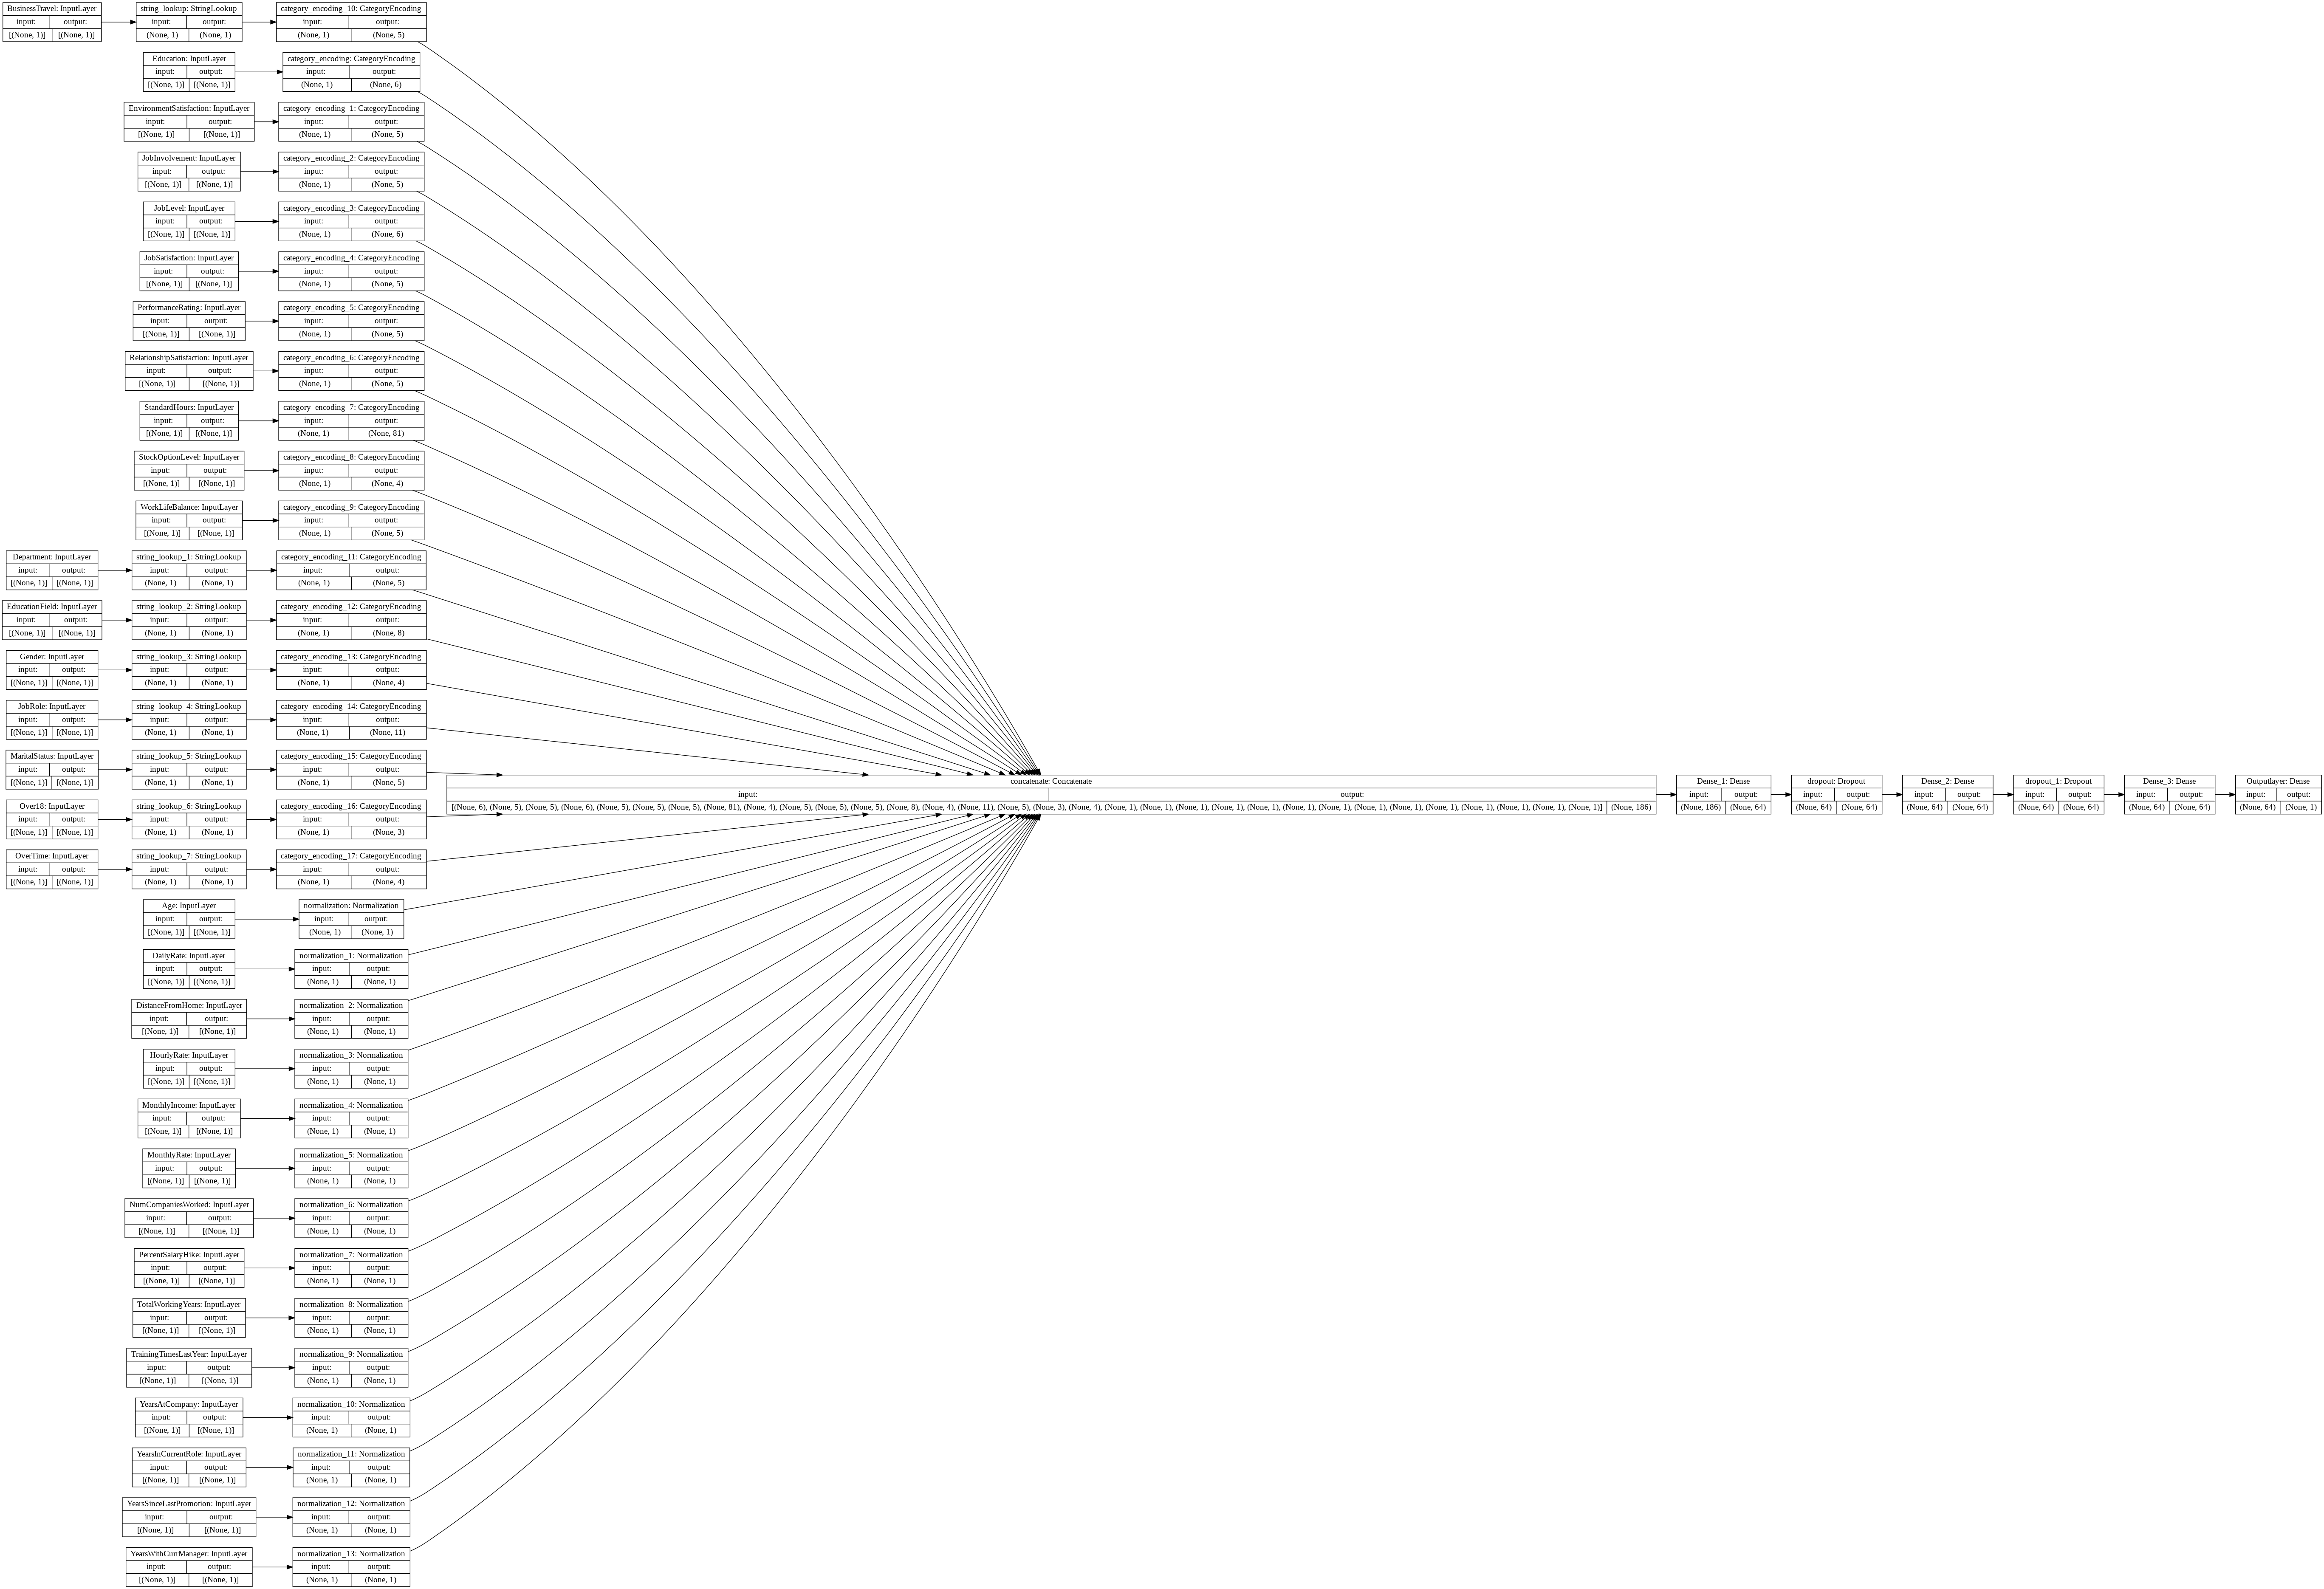

In [15]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

# Checkpoints

I want to use keras callbacks checkout to save the model at the best accuracy possible

In [16]:
!mkdir checkpoints
!ls

mkdir: cannot create directory ‘checkpoints’: File exists
checkpoints  model.png	sample_data


In [17]:
checkpoint = ModelCheckpoint('./checkpoints/best_weights.tf', monitor='accuracy', verbose=1, save_best_only=True, mode='auto')

#Save History
Save training in "History" so that I can plot it later

In [18]:
history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[checkpoint])


Epoch 1/100
 1/13 [=>............................] - ETA: 17s - loss: 0.6863 - accuracy: 0.4688
Epoch 00001: accuracy improved from -inf to 0.76428, saving model to ./checkpoints/best_weights.tf


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2292: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:1377: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


INFO:tensorflow:Assets written to: ./checkpoints/best_weights.tf/assets
13/13 [==============================] - 9s 632ms/step - loss: 0.5994 - accuracy: 0.6800 - val_loss: 0.4447 - val_accuracy: 0.8252
Epoch 2/100
12/13 [==========================>...] - ETA: 0s - loss: 0.4770 - accuracy: 0.8236
Epoch 00002: accuracy improved from 0.76428 to 0.82989, saving model to ./checkpoints/best_weights.tf
INFO:tensorflow:Assets written to: ./checkpoints/best_weights.tf/assets
13/13 [==============================] - 6s 535ms/step - loss: 0.4736 - accuracy: 0.8245 - val_loss: 0.4283 - val_accuracy: 0.8252
Epoch 3/100
12/13 [==========================>...] - ETA: 0s - loss: 0.4544 - accuracy: 0.8186
Epoch 00003: accuracy did not improve from 0.82989
13/13 [==============================] - 0s 8ms/step - loss: 0.4504 - accuracy: 0.8202 - val_loss: 0.4129 - val_accuracy: 0.8252
Epoch 4/100
12/13 [==========================>...] - ETA: 0s - loss: 0.3808 - accuracy: 0.8543
Epoch 00004: accuracy did n

# Plot history

In [19]:
def plot_train(hist):
    h = hist.history
    if 'accuracy' in h:
        meas='accuracy'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)

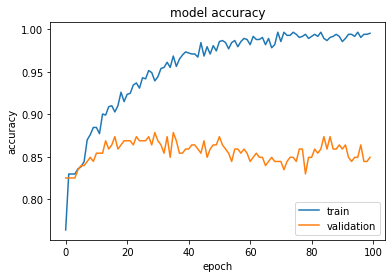

In [20]:
plot_train(history)

# Predict one sample employee data
(Taken from row 2 of test dataset [Employee Attrition test](https://docs.google.com/spreadsheets/d/e/2PACX-1vRsxR0nTrEaCqfro4FvGNDn6ZYYdQS0e2Tev1SMtJ5jYIjU0WGp77hp6btdJYkMl3XAk4lA01hxE30o/pub?gid=2057317048&single=true&output=csv) )





In [21]:
sample = {
    "Education": 2,
    "EnvironmentSatisfaction": 4,
    "JobInvolvement": 4,
    "JobLevel": 2,
    "JobSatisfaction": 1,
    "PerformanceRating": 3,
    "RelationshipSatisfaction": 3,
    "StandardHours": 80,
    "StockOptionLevel": 2,
    "WorkLifeBalance": 3,
    "BusinessTravel": "Travel_Rarely",
    "Department":"Research & Development",
    "EducationField":"Medical",
    "Gender":"Female",
    "JobRole":"Manufacturing Director",
    "MaritalStatus":"Divorced",
    "Over18":"Y",
    "OverTime":"No",
    "Age": 53,
    "DailyRate": 1084,
    "DistanceFromHome": 13,
    "HourlyRate": 57,
    "MonthlyIncome": 4450,
    "MonthlyRate": 26250,
    "NumCompaniesWorked": 1,
    "PercentSalaryHike": 11,
    "TotalWorkingYears": 5,
    "TrainingTimesLastYear": 3,
    "YearsAtCompany": 4,
    "YearsInCurrentRole": 2,
    "YearsSinceLastPromotion": 1,
    "YearsWithCurrManager": 3,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
model.predict(input_dict)

array([[4.7331015e-15]], dtype=float32)

# Predict all employees from test dataset
Predict all employees from test dataset (441) 

In [22]:
predictions = []

for employee in test_ds:
    input_dict = {name: tf.convert_to_tensor([value]) for name, value in employee.items()}
    probability = model.predict(input_dict)
    employee_number = tf.get_static_value(employee["EmployeeNumber"])
    employee_age = tf.get_static_value(employee["Age"])
    employee_monthly_income = tf.get_static_value(employee["MonthlyIncome"])
    employee_satisfaction = tf.get_static_value(employee["JobSatisfaction"]) * tf.get_static_value(employee["RelationshipSatisfaction"])
    if(math.isnan(probability)):
      #Test data has missing features that cause the model to be unable to determine employee attrition %
      print(
        "We do not have a good prediction as to whether Employee Number %d will leave"
        % (employee_number)
      )
      predictions.append({
                          "Age": employee_age,
                          "MonthlyIncome":employee_monthly_income,
                          "Satisfaction":employee_satisfaction,
                          "prediction":0
                        })
    elif(probability <0.5):
      #Employee has low chance of leaving (Less than 50%)
      print(
          "Employee Number %d has a low chance of leaving (%f)"
          % (employee_number, probability)
      )
      predictions.append({
                          "Age": employee_age,
                          "MonthlyIncome":employee_monthly_income,
                          "Satisfaction":employee_satisfaction,
                          "prediction":1
                        })
    else:
      #Employee has high chance of leaving (Less than 50%)
      print(
          "Employee Number %d has a high chance of leaving (%f)"
          % (employee_number, probability)
      )
      predictions.append({
                    "Age": employee_age,
                    "MonthlyIncome":employee_monthly_income,
                    "Satisfaction":employee_satisfaction,
                    "prediction":2
                  })

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['EmployeeCount', 'EmployeeNumber'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


We do not have a good prediction as to whether Employee Number 671 will leave
We do not have a good prediction as to whether Employee Number 1044 will leave
We do not have a good prediction as to whether Employee Number 1471 will leave
We do not have a good prediction as to whether Employee Number 577 will leave
We do not have a good prediction as to whether Employee Number 1662 will leave
Employee Number 81 has a low chance of leaving (0.000154)
Employee Number 723 has a low chance of leaving (0.000046)
We do not have a good prediction as to whether Employee Number 105 will leave
Employee Number 2065 has a low chance of leaving (0.000000)
Employee Number 366 has a low chance of leaving (0.000000)
Employee Number 271 has a low chance of leaving (0.000002)
Employee Number 374 has a low chance of leaving (0.006102)
Employee Number 1196 has a low chance of leaving (0.000000)
Employee Number 1745 has a low chance of leaving (0.000025)
Employee Number 349 has a low chance of leaving (0.0000

#Chart Prediction Data

Display graphically using histograms

**1. By Age**

Text(0.5, 1.0, 'Employee attrition probability by age')

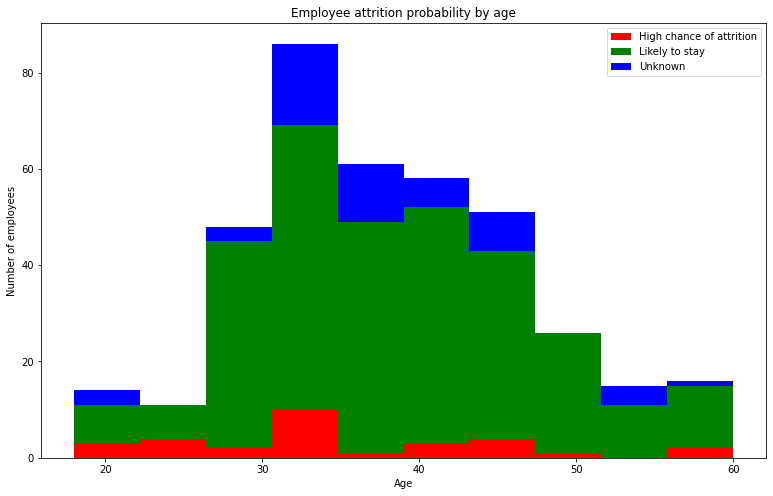

In [23]:
figure = plt.figure(figsize=(13,8))
predictions_frame= pd.DataFrame(predictions)
plt.hist([predictions_frame[predictions_frame['prediction']==2]['Age'],predictions_frame[predictions_frame['prediction']==1]['Age'],predictions_frame[predictions_frame['prediction']==0]['Age']], stacked=True, color = ['r','g','b'],
         label = ['High chance of attrition','Likely to stay','Unknown'])
plt.xlabel('Age')
plt.ylabel('Number of employees')
plt.legend()
plt.title("Employee attrition probability by age")

**2. By Monthly Income**

Text(0.5, 1.0, 'Employee attrition probability by Monthly Income')

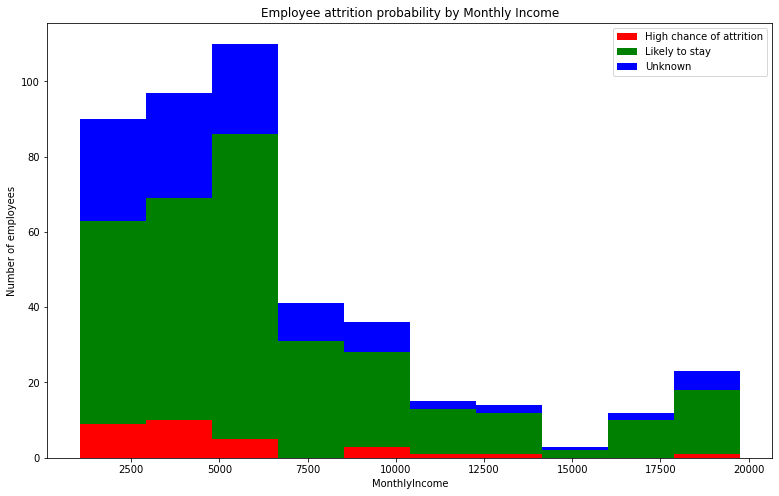

In [24]:
figure = plt.figure(figsize=(13,8))
predictions_frame= pd.DataFrame(predictions)
plt.hist([predictions_frame[predictions_frame['prediction']==2]['MonthlyIncome'],predictions_frame[predictions_frame['prediction']==1]['MonthlyIncome'],predictions_frame[predictions_frame['prediction']==0]['MonthlyIncome']], stacked=True, color = ['r','g','b'],
         label = ['High chance of attrition','Likely to stay','Unknown'])
plt.xlabel('MonthlyIncome')
plt.ylabel('Number of employees')
plt.legend()
plt.title("Employee attrition probability by Monthly Income")

**3. By Employee Satisfaction**

Employee Satisfaction = Job Satisfaction * Relationship Satisfaction

Text(0.5, 1.0, 'Employee attrition probability by Overall Satisfaction')

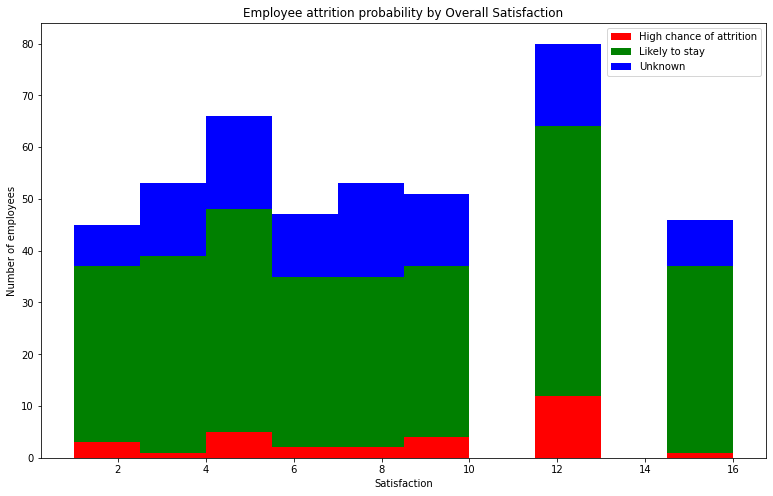

In [25]:
figure = plt.figure(figsize=(13,8))
predictions_frame= pd.DataFrame(predictions)
plt.hist([predictions_frame[predictions_frame['prediction']==2]['Satisfaction'],predictions_frame[predictions_frame['prediction']==1]['Satisfaction'],predictions_frame[predictions_frame['prediction']==0]['Satisfaction']], stacked=True, color = ['r','g','b'],
         label = ['High chance of attrition','Likely to stay','Unknown'])
plt.xlabel('Satisfaction')
plt.ylabel('Number of employees')
plt.legend()
plt.title("Employee attrition probability by Overall Satisfaction")